<a href="https://colab.research.google.com/github/imenebak/MLOps-coursera-DeepLearning.ai/blob/main/C1W3_Data_Labeling_Ungraded_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
!unzip "/content/Files.zip"

Archive:  /content/Files.zip
  inflating: Files/Youtube01-Psy.csv  
  inflating: Files/Youtube02-KatyPerry.csv  
  inflating: Files/Youtube03-LMFAO.csv  
  inflating: Files/Youtube04-Eminem.csv  
  inflating: Files/Youtube05-Shakira.csv  


**Loading the dataset**
The dataset consists of 5 CSV files, one for each video. Pandas DataFrame are very powerful to handle data in CSV format. The following helper function will load the data using pandas:

In [26]:
def load_labeled_spam_dataset():
    """Load labeled spam dataset."""

    # Path where csv files are located
    base_path = "/content/Files/"

    # List of csv files with full path
    csv_files = [os.path.join(base_path, csv) for csv in glob.glob(base_path+"*.csv")]

    # List of dataframes for each file
    dfs = [pd.read_csv(filename) for filename in csv_files]

    # Concatenate dataframes into a single one
    df = pd.concat(dfs)

    # Rename columns
    df = df.rename(columns={"CONTENT": "text", "CLASS": "label"})

    # Set a seed for the order of rows
    df = df.sample(frac=1, random_state=824)
    
    return df.reset_index()


# Save the dataframe into the df_labeled variable
df_labeled = load_labeled_spam_dataset()

In [27]:
# Take a look at the first 5 rows
df_labeled.head()

,index,COMMENT_ID,AUTHOR,DATE,text,label
0,106,z12njp45xonlypf2x23ketjjpzjee3cyt04,bea boots,2014-09-14T12:42:56,great song you go katy!﻿,0
1,311,_2viQ_Qnc68ked0J7OAfephXPfR-pvW7HiuIC5ZRduI,macgyver16,2013-08-16T14:07:09.668000,adf.ly /KlD3Y,1
2,250,z12hif0a3nj0vlkxj04cif1wcpuxvf0gpno0k,Hazetrix (EHazardStudio),2015-04-08T00:09:33.033000,hey guys im 17 years old remixer and producer ...,1
3,255,z132t3fhixrdghdhu04ciz2i4ovhezcgnrc0k,Law Halkett,2015-03-29T07:12:48.792000,Check out this video on YouTube: <br />﻿,1
4,346,_2viQ_Qnc68cxHfQzecR1L9f-hbLNIJ7VxpCZtctPMk,yakikukamo FIRELOVER,2013-07-18T17:07:06.152000,hey you ! check out the channel of Alvar Lake !!,1


*Further inspection and preprocessing*

**Checking for data imbalance**

It is fairly common to assume that the data you are working on is balanced. This means that the dataset contains a similar proportion of examples for all classes. Before moving forward let's actually test this assumption:

Value counts for each class:

1    1005
0     951
Name: label, dtype: int64



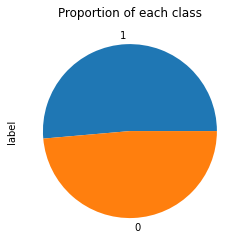

In [28]:
# Print actual value count
print(f"Value counts for each class:\n\n{df_labeled.label.value_counts()}\n")

# Display pie chart to visually check the proportion
df_labeled.label.value_counts().plot.pie(y='label', title='Proportion of each class')
plt.show()

*There is roughly the same number of data points for each class so class imbalance is not an issue for this particular dataset.*

**Cleaning the dataset**

If you scroll back to the cell where you inspected the data, you will realize that the dataframe includes information that is not relevant for the task at hand. At the moment, you are only interested in the comments and the corresponding labels (the video that each comment belongs to will be used later). Let's drop the remaining columns.

In [29]:
# Drop unused columns
df_labeled = df_labeled.drop(['index', 'COMMENT_ID', 'AUTHOR', 'DATE'], axis=1)

# Look at the cleaned dataset
df_labeled.head()

,text,label
0,great song you go katy!﻿,0
1,adf.ly /KlD3Y,1
2,hey guys im 17 years old remixer and producer ...,1
3,Check out this video on YouTube: <br />﻿,1
4,hey you ! check out the channel of Alvar Lake !!,1


In [30]:
from sklearn.model_selection import train_test_split

# Save the text into the X variable
X = df_labeled.drop("label", axis=1)

# Save the true labels into the y variable
y = df_labeled["label"]

# Use 1/5 of the data for testing later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print number of comments for each set
print(f"There are {X_train.shape[0]} comments for training.")
print(f"There are {X_test.shape[0]} comments for testing")

There are 1564 comments for training.
There are 392 comments for testing


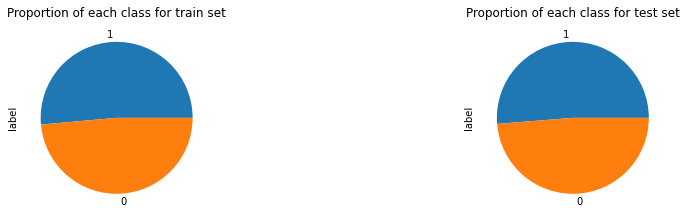

In [31]:
plt.subplot(1, 3, 1)
y_train.value_counts().plot.pie(y='label', title='Proportion of each class for train set', figsize=(10, 6))

plt.subplot(1, 3, 3)
y_test.value_counts().plot.pie(y='label', title='Proportion of each class for test set', figsize=(10, 6))

plt.tight_layout()
plt.show()

*Both, the training and test sets a balanced proportion of examples per class. So, the code successfully implemented stratification.*


**Data Labeling**

Establishing performance lower and upper bounds for reference
To properly compare different labeling strategies you need to establish a baseline for model accuracy, in this case you will establish both a lower and an upper bound to compare against.

Calculate accuracy of a labeling strategy
CountVectorizer is a handy tool included in the sklearn ecosystem to encode text based data.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# Allow unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1, 5))

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB


def calculate_accuracy(X_tr, y_tr, X_te=X_test, y_te=y_test, 
                       clf=MultinomialNB(), vectorizer=vectorizer):
    
    # Encode train text
    X_train_vect = vectorizer.fit_transform(X_tr.text.tolist())
    
    # Fit model
    clf.fit(X=X_train_vect, y=y_tr)
    
    # Vectorize test text
    X_test_vect = vectorizer.transform(X_te.text.tolist())
    
    # Make predictions for the test set
    preds = clf.predict(X_test_vect)
    
    # Return accuracy score
    return accuracy_score(preds, y_te)

In [39]:
# Empty dictionary
accs = dict()

**Random Labeling**

Generating random labels is a natural way to establish a lower bound. You will expect that any successful alternative labeling model to outperform randomly generated labels.

Now let's calculate the accuracy for the random labeling method

In [37]:
# Calculate random labels
rnd_labels = np.random.randint(0, 2, X_train.shape[0])

# Feed them alongside X_train to calculate_accuracy function
rnd_acc = calculate_accuracy(X_train, rnd_labels)

rnd_acc

0.5

In [40]:
# Empty list to save accuracies
rnd_accs = []

for _ in range(10):
    # Add every accuracy to the list
    rnd_accs.append(calculate_accuracy(X_train, np.random.randint(0, 2, X_train.shape[0])))

# Save result in accs dictionary
accs['random-labels'] = sum(rnd_accs)/len(rnd_accs)

# Print result
print(f"The random labelling method achieved and accuracy of {accs['random-labels']*100:.2f}%")

The random labelling method achieved and accuracy of 50.13%


In [41]:
# Calculate accuracy when using the true labels
true_acc = calculate_accuracy(X_train, y_train)

# Save the result
accs['true-labels'] = true_acc

print(f"The true labelling method achieved and accuracy of {accs['true-labels']*100:.2f}%")

The true labelling method achieved and accuracy of 92.86%


In [42]:
def labeling_rules_1(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules
    rules = [
        "free" in x,
        "subs" in x,
        "http" in x
    ]
    
    # If the comment falls under any of the rules classify as SPAM
    if any(rules):
        return 1
    
    # Otherwise, NO_LABEL
    return -1

In [43]:
# Apply the rules the comments in the train set
labels = [labeling_rules_1(label) for label in X_train.text]

# Convert to a numpy array
labels = np.asarray(labels)

# Take a look at the automatic labels
labels

array([-1, -1, -1, ...,  1, -1, -1])

In [44]:
# Create the automatic labeled version of X_train by removing points with NO_LABEL label
X_train_al = X_train[labels != -1]

# Remove predictions with NO_LABEL label
labels_al = labels[labels != -1]

print(f"Predictions with concrete label have shape: {labels_al.shape}")

print(f"Proportion of data points kept: {labels_al.shape[0]/labels.shape[0]*100:.2f}%")

Predictions with concrete label have shape: (375,)
Proportion of data points kept: 23.98%


In [45]:
# Compute accuracy when using these labels
iter_1_acc = calculate_accuracy(X_train_al, labels_al)

# Display accuracy
print(f"First iteration of automatic labeling has an accuracy of {iter_1_acc*100:.2f}%")

# Save the result
accs['first-iteration'] = iter_1_acc

First iteration of automatic labeling has an accuracy of 51.28%


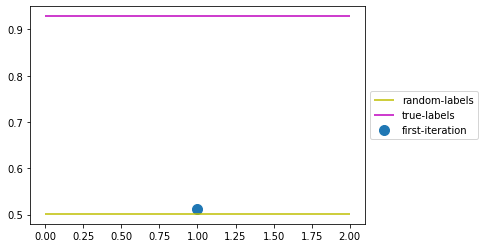

In [46]:
def plot_accuracies(accs=accs):
    colors = list("rgbcmy")
    items_num = len(accs)
    cont = 1

    for x, y in accs.items():
        if x in ['true-labels', 'random-labels', 'true-labels-best-clf']:
            plt.hlines(y, 0, (items_num-2)*2, colors=colors.pop())
        else:
            plt.scatter(cont, y, s=100)
            cont+=2
    plt.legend(accs.keys(), loc="center left",bbox_to_anchor=(1, 0.5))
    plt.show()
    
plot_accuracies()

In [47]:
def label_given_rules(df, rules_function, name, 
                      accs_dict=accs, verbose=True):
    
    # Apply labeling rules to the comments
    labels = [rules_function(label) for label in df.text]
    
    # Convert to a numpy array
    labels = np.asarray(labels)
    
    # Save initial number of data points
    initial_size = labels.shape[0]
    
    # Trim points with NO_LABEL label
    X_train_al = df[labels != -1]
    labels = labels[labels != -1]
    
    # Save number of data points after trimming
    final_size = labels.shape[0]
    
    # Compute accuracy
    acc = calculate_accuracy(X_train_al, labels)
    
    # Print useful information
    if verbose:
        print(f"Proportion of data points kept: {final_size/initial_size*100:.2f}%\n")
        print(f"{name} labeling has an accuracy of {acc*100:.2f}%\n")
        
    # Save accuracy to accuracies dictionary
    accs_dict[name] = acc
    
    return X_train_al, labels, acc

In [48]:
def labeling_rules_2(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x
    ]
    
    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    
    if any(spam_rules):
        return 1
    
    return -1

Proportion of data points kept: 44.05%

second-iteration labeling has an accuracy of 72.19%



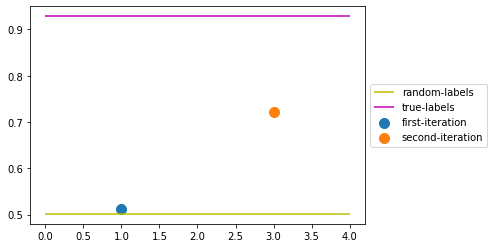

In [49]:
label_given_rules(X_train, labeling_rules_2, "second-iteration")

plot_accuracies()

In [50]:
from statistics import mean

print(f"NOT_SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==0].text]):.2f} characters.")
print(f"SPAM comments have an average of {mean([len(t) for t in df_labeled[df_labeled.label==1].text]):.2f} characters.")

NOT_SPAM comments have an average of 49.64 characters.
SPAM comments have an average of 137.34 characters.


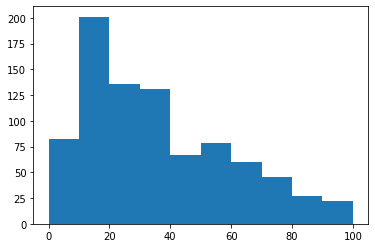

In [51]:
plt.hist([len(t) for t in df_labeled[df_labeled.label==0].text], range=(0,100))
plt.show()

In [53]:
def labeling_rules_3(x):
    
    # Convert text to lowercase
    x = x.lower()
    
    # Define list of rules to classify as NOT_SPAM
    not_spam_rules = [
        "view" in x,
        "song" in x,
        len(x) < 30
    ]
    

    # Define list of rules to classify as SPAM
    spam_rules = [
        "free" in x,
        "subs" in x,
        "gift" in x,
        "follow" in x,
        "http" in x,
        "check out" in x
    ]
    
    # Classify depending on the rules
    if any(not_spam_rules):
        return 0
    if any(spam_rules):
        return 1
    
    return -1

Proportion of data points kept: 77.49%

third-iteration labeling has an accuracy of 90.05%



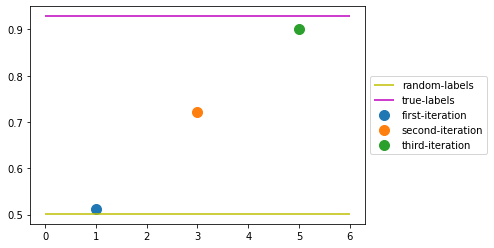

In [54]:
label_given_rules(X_train, labeling_rules_3, "third-iteration")

plot_accuracies()